In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("all_data_labeled_att_Rel.csv")
bands = ['delta', 'theta', 'lowAlpha', 'highAlpha', 'lowBeta', 'highBeta', 'lowGamma', 'highGamma']
EPS = 1e-6


In [2]:
# Band sums & ratios
df['alpha_sum'] = df['lowAlpha'] + df['highAlpha']
df['beta_sum'] = df['lowBeta'] + df['highBeta']
df['theta_beta'] = df['theta'] / (df['beta_sum'] + EPS)
df['alpha_beta'] = df['alpha_sum'] / (df['beta_sum'] + EPS)
df['lowHigh_alpha'] = df['lowAlpha'] / (df['highAlpha'] + EPS)
df['lowHigh_beta'] = df['lowBeta'] / (df['highBeta'] + EPS)
df['gamma_beta'] = (df['lowGamma'] + df['highGamma']) / (df['beta_sum'] + EPS)
df['alpha_theta'] = df['alpha_sum'] / (df['theta'] + EPS)
df['beta_theta'] = df['beta_sum'] / (df['theta'] + EPS)
df['alpha_theta_beta'] = df['alpha_sum'] / (df['theta'] + df['beta_sum'] + EPS)
df['theta_alpha'] = df['theta'] / (df['alpha_sum'] + EPS)
df['gamma_alpha'] = (df['lowGamma'] + df['highGamma']) / (df['alpha_sum'] + EPS)

# Rolling stats (window=10)
window_feat = 10
for band in bands:
    df[f'{band}_mean'] = df[band].rolling(window_feat, min_periods=1).mean()
    df[f'{band}_std'] = df[band].rolling(window_feat, min_periods=1).std().fillna(0)
    df[f'{band}_min'] = df[band].rolling(window_feat, min_periods=1).min()
    df[f'{band}_max'] = df[band].rolling(window_feat, min_periods=1).max()

# Deltas: change in each band over last 10 samples
for band in bands:
    df[f'{band}_delta'] = df[band] - df[band].shift(window_feat).fillna(method='bfill')

# Normalized band power for each band (per row)
total_power = df[bands].sum(axis=1) + EPS
for band in bands:
    df[f'{band}_norm'] = df[band] / total_power

# List of all engineered features
ratios = [
    'theta_beta', 'alpha_beta', 'lowHigh_alpha', 'lowHigh_beta', 'gamma_beta',
    'alpha_theta', 'beta_theta', 'alpha_theta_beta', 'theta_alpha', 'gamma_alpha'
]
rollings = [f"{b}_{stat}" for b in bands for stat in ['mean', 'std', 'min', 'max']]
deltas = [f"{b}_delta" for b in bands]
norms = [f"{b}_norm" for b in bands]
feature_cols = bands + ratios + rollings + deltas + norms


C:\Users\Moustafa\AppData\Local\Temp\ipykernel_26740\2389032923.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f'{band}_delta'] = df[band] - df[band].shift(window_feat).fillna(method='bfill')
C:\Users\Moustafa\AppData\Local\Temp\ipykernel_26740\2389032923.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f'{band}_delta'] = df[band] - df[band].shift(window_feat).fillna(method='bfill')
C:\Users\Moustafa\AppData\Local\Temp\ipykernel_26740\2389032923.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f'{band}_delta'] = df[band] - df[band].shift(window_feat).fillna(method='bfill')
C:\Users\Moustafa\AppData\Local\Temp\ipykernel_26740\2389032923.py:25: FutureWarning: Series.fillna with 'method' is deprecated an

In [3]:
def create_sequences_mode_label(df, feature_cols, label_cols, window_size=100, step=2):
    X_seq, y1_seq, y2_seq = [], [], []
    def most_common(arr):
        values, counts = np.unique(arr, return_counts=True)
        return values[np.argmax(counts)]
    for i in range(0, len(df) - window_size, step):
        window = df.iloc[i:i+window_size]
        X_seq.append(window[feature_cols].values)
        y1_seq.append(most_common(window[label_cols[0]].values))
        y2_seq.append(most_common(window[label_cols[1]].values))
    return np.array(X_seq), np.array(y1_seq), np.array(y2_seq)


In [4]:
# 1. Create sequences (use the fixed function from above)
label_cols = ['attention_label', 'relaxation_label']

X, y_att, y_rel = create_sequences_mode_label(df, feature_cols, label_cols, window_size=20, step=2)

# 2. Label encoding for y_att, y_rel
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le_att = LabelEncoder()
le_rel = LabelEncoder()
y_att_enc = le_att.fit_transform(y_att)
y_rel_enc = le_rel.fit_transform(y_rel)
y_att_oh = to_categorical(y_att_enc)
y_rel_oh = to_categorical(y_rel_enc)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_att_train, y_att_test, y_rel_train, y_rel_test = train_test_split(
    X, y_att_oh, y_rel_oh, test_size=0.2, random_state=42, stratify=y_att
)


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

input_layer = Input(shape=(X.shape[1], X.shape[2]), name="eeg_input")
x = Conv1D(128, 7, activation="relu", padding="same")(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 5, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.1))(x)
x = Bidirectional(LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.1))(x)
x = Dropout(0.5)(x)

# Output heads
att_out = Dense(64, activation="relu")(x)
att_out = Dropout(0.2)(att_out)
att_out = Dense(y_att_oh.shape[1], activation="softmax", name="att_output")(att_out)

rel_out = Dense(64, activation="relu")(x)
rel_out = Dropout(0.2)(rel_out)
rel_out = Dense(y_rel_oh.shape[1], activation="softmax", name="rel_output")(rel_out)

model = Model(inputs=input_layer, outputs=[att_out, rel_out])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss={"att_output": "categorical_crossentropy", "rel_output": "categorical_crossentropy"},
    metrics={"att_output": "accuracy", "rel_output": "accuracy"}
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ eeg_input           │ (None, 20, 66)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 20, 128)   │     59,264 │ eeg_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 20, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 10, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 128)   │     82,048 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 5, 128)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 5, 128)    │     98,816 │ max_pooling1d_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_output (Dense)  │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rel_output (Dense)  │ (None, 3)         │        195 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 291,078 (1.11 MB)

 Trainable params: 290,566 (1.11 MB)

 Non-trainable params: 512 (2.00 KB)

In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=4, min_lr=1e-5)
]


history = model.fit(
    X_train, {"att_output": y_att_train, "rel_output": y_rel_train},
    validation_data=(X_test, {"att_output": y_att_test, "rel_output": y_rel_test}),
    epochs=80, batch_size=64, callbacks=callbacks
)



Epoch 1/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - att_output_accuracy: 0.4389 - att_output_loss: 1.0628 - loss: 2.0145 - rel_output_accuracy: 0.6237 - rel_output_loss: 0.9517 - val_att_output_accuracy: 0.5516 - val_att_output_loss: 1.0290 - val_loss: 1.8089 - val_rel_output_accuracy: 0.7208 - val_rel_output_loss: 0.7820 - learning_rate: 5.0000e-04
Epoch 2/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - att_output_accuracy: 0.5563 - att_output_loss: 0.9657 - loss: 1.7338 - rel_output_accuracy: 0.7318 - rel_output_loss: 0.7681 - val_att_output_accuracy: 0.5431 - val_att_output_loss: 0.9909 - val_loss: 1.7584 - val_rel_output_accuracy: 0.7208 - val_rel_output_loss: 0.7690 - learning_rate: 5.0000e-04
Epoch 3/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - att_output_accuracy: 0.5571 - att_output_loss: 0.9374 - loss: 1.7108 - rel_output_accuracy: 0.7084 - rel_output_loss: 0.7734 - val_att_output_accuracy: 0.5533 - val_att_output_loss: 0.9213 - val_loss: 1.6665 - val_rel_output_accuracy: 0.720

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step
Attention Report:
              precision    recall  f1-score   support

        High       0.92      0.85      0.89       157
         Low       0.91      0.94      0.92       108
      Medium       0.92      0.94      0.93       326

    accuracy                           0.92       591
   macro avg       0.92      0.91      0.91       591
weighted avg       0.92      0.92      0.92       591

Relaxation Report:
              precision    recall  f1-score   support

        High       0.80      0.85      0.82       113
         Low       0.79      0.79      0.79        52
      Medium       0.94      0.92      0.93       426

    accuracy                           0.90       591
   macro avg       0.84      0.85      0.85       591
weighted avg       0.90      0.90      0.90       591



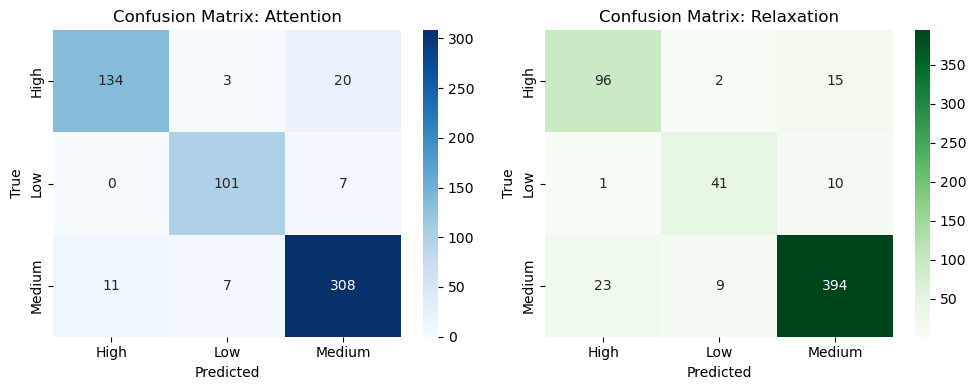

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
att_pred_probs, rel_pred_probs = model.predict(X_test)
att_pred = np.argmax(att_pred_probs, axis=1)
rel_pred = np.argmax(rel_pred_probs, axis=1)
y_att_true = np.argmax(y_att_test, axis=1)
y_rel_true = np.argmax(y_rel_test, axis=1)

print("Attention Report:")
print(classification_report(y_att_true, att_pred, target_names=le_att.classes_))
print("Relaxation Report:")
print(classification_report(y_rel_true, rel_pred, target_names=le_rel.classes_))

# Confusion Matrices
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_att_true, att_pred), annot=True, fmt='d', cmap="Blues",
            xticklabels=le_att.classes_, yticklabels=le_att.classes_)
plt.title("Confusion Matrix: Attention")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_rel_true, rel_pred), annot=True, fmt='d', cmap="Greens",
            xticklabels=le_rel.classes_, yticklabels=le_rel.classes_)
plt.title("Confusion Matrix: Relaxation")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [9]:
model.save("best_eeg_cnn_bilstm.h5")

In [7]:
np.save("le_att_classes.npy", le_att.classes_)
np.save("le_rel_classes.npy", le_rel.classes_)


In [8]:
# Save your full feature_cols from training
import json
with open("feature_cols.json", "w") as f:
    json.dump(feature_cols, f)
